# Exploration for Dunnhumby The-Complete-Journey

## Table

**Data table**
- campaign_table
- transaction_data
- hh_demographic

**Lookup table**
- campaign_desc
- coupon
- coupon_redempt
- product


```
hh_demographic ──┐
                 │
                 ├─→ transaction_data ←─→ product
                 │         ↓
campaign_table ──┘         ↓
      ↓              causal_data
campaign_desc            
      ↓
    coupon ←──→ coupon_redempt
```

---

## EDA Plan


### 1. Household Demographics (`hh_demographic`)
- **Distribution analysis** of variables
- **Correlation analysis** between demographic segments

### 2. Transaction Patterns (`transaction_data`)
- **Transaction metrics** by household, time, and store
  - Sales value, visit frequency, discount usage, actual amount paid
- **Customer segmentation** comparison
  - High spenders vs. low spenders
  - Heavy discount users vs. full-price buyers
  - Frequent vs. occasional shoppers
- **Behavioral metrics**
  - Repeat purchase rate
  - Customer retention patterns
  - Discount sensitivity analysis

### 3. Product Analysis (`product`)
- **Product distribution** across departments, commodities, and sub-commodities
- **Preference analysis**
  - Popular items and categories
  - Brand preference (National vs. Private label)
  - Manufacturer concentration
- **User-item matrix** 

### 4. Campaign Analysis (`campaign_table` + `campaign_desc` + `coupon_redempt`)
- **Campaign planning overview**
  - Timeline and schedule by campaign type
  - Campaign duration comparison (TypeA vs. TypeB vs. TypeC)
- **Campaign assignment patterns**
  - Number of campaigns per household
  - Campaign intervals and overlapping periods
  - Demographic distribution across campaign types
- **Participation metrics**
  - Campaign participation rate (overall and by type)
  - Demographic differences in participation

### 5. Coupon Redemption Analysis (`coupon` + `coupon_redempt`)
- **Redemption rate** by:
  - Overall and by campaign type
  - Demographic segments
  - Time since campaign start
- **Redemption behavior**
  - Time to redemption
  - Multiple coupon redemption patterns
  - New product trial vs. existing product purchase

### 6. Marketing Exposure (`causal_data`)
- **Display and mailer distribution** by product category
- **Exposure impact analysis**
  - Relationship between display/mailer exposure and sales performance
  - Combined effects of marketing channels

---

**Note**: This EDA focuses on foundational patterns and distributions. Advanced causal inference and predictive modeling will be conducted in subsequent analyses.RetryClaude can make mistakes. Please double-check responses.


In [64]:
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tools import categorical

PROJECT_PATH = Path('.').absolute().parents[0]
DATA_PATH = Path(PROJECT_PATH, 'raw')

print('Project path: ', PROJECT_PATH)
print('Data path: ', DATA_PATH)

Project path:  E:\project\side-project\data\dunnhumby
Data path:  E:\project\side-project\data\dunnhumby\raw


In [9]:
list(map(lambda pth: pth.name, DATA_PATH.rglob('*.csv')))

['campaign_desc.csv',
 'campaign_table.csv',
 'causal_data.csv',
 'coupon.csv',
 'coupon_redempt.csv',
 'hh_demographic.csv',
 'product.csv',
 'transaction_data.csv']

## Exploration

### 1. Household Demographics (`hh_demographic`)

Only 801 householders have demographic information available. There are no null values in any column for these 801 householders.


In [24]:
column_mapping = {
    'classification_1': 'AGE_GRP',           
    'classification_2': 'MARITAL',    # 추정
    'classification_3': 'INCOME_GRP',        
    'classification_4': 'HOUSEHOLD_SIZE',      
    'classification_5': 'HOUSEHOLD_COMPOSITION',
    'HOMEOWNER_DESC': 'HOMEOWNER_DESC',        # 이미 올바름
    'KID_CATEGORY_DESC': 'KID_CATEGORY_DESC',  # 이미 올바름
}


df_demo = pd.read_csv(
    DATA_PATH / 'hh_demographic.csv'
).rename(columns=column_mapping)
                                                                                                                        
df_demo.head()                                                                                              

,AGE_GRP,MARITAL,INCOME_GRP,HOMEOWNER_DESC,HOUSEHOLD_COMPOSITION,HOUSEHOLD_SIZE,KID_CATEGORY_DESC,household_key
0,Age Group6,X,Level4,Homeowner,Group5,2,None/Unknown,1
1,Age Group4,X,Level5,Homeowner,Group5,2,None/Unknown,7
2,Age Group2,Y,Level3,Unknown,Group4,3,1,8
3,Age Group2,Y,Level6,Homeowner,Group4,4,2,13
4,Age Group4,Z,Level5,Homeowner,Group3,1,None/Unknown,16


In [25]:
len(df_demo)

801

In [26]:
df_demo.isnull().sum().to_frame().T

,AGE_GRP,MARITAL,INCOME_GRP,HOMEOWNER_DESC,HOUSEHOLD_COMPOSITION,HOUSEHOLD_SIZE,KID_CATEGORY_DESC,household_key
0,0,0,0,0,0,0,0,0


In [27]:
fn_cat_grp_cnt = lambda col: (
    df_demo.groupby(by=col)['household_key'].count().to_frame().assign(**{
        'count': lambda elem: elem['household_key'],
        'proportion': lambda elem: elem['household_key'] / len(df_demo)
    }).drop('household_key', axis=1)
)

for col in df_demo.columns[:-1]:
    print('=====' * 5, col)
    print(fn_cat_grp_cnt(col).round(3).to_markdown())
    print(' \n')

========================= AGE_GRP
| AGE_GRP    |   count |   proportion |
|:-----------|--------:|-------------:|
| Age Group1 |      46 |        0.057 |
| Age Group2 |     142 |        0.177 |
| Age Group3 |     194 |        0.242 |
| Age Group4 |     288 |        0.36  |
| Age Group5 |      59 |        0.074 |
| Age Group6 |      72 |        0.09  |
 

========================= MARITAL
| MARITAL   |   count |   proportion |
|:----------|--------:|-------------:|
| X         |     340 |        0.424 |
| Y         |     344 |        0.429 |
| Z         |     117 |        0.146 |
 

========================= INCOME_GRP
| INCOME_GRP   |   count |   proportion |
|:-------------|--------:|-------------:|
| Level1       |      61 |        0.076 |
| Level10      |      11 |        0.014 |
| Level11      |       5 |        0.006 |
| Level12      |      11 |        0.014 |
| Level2       |      74 |        0.092 |
| Level3       |      77 |        0.096 |
| Level4       |     172 |        0.21

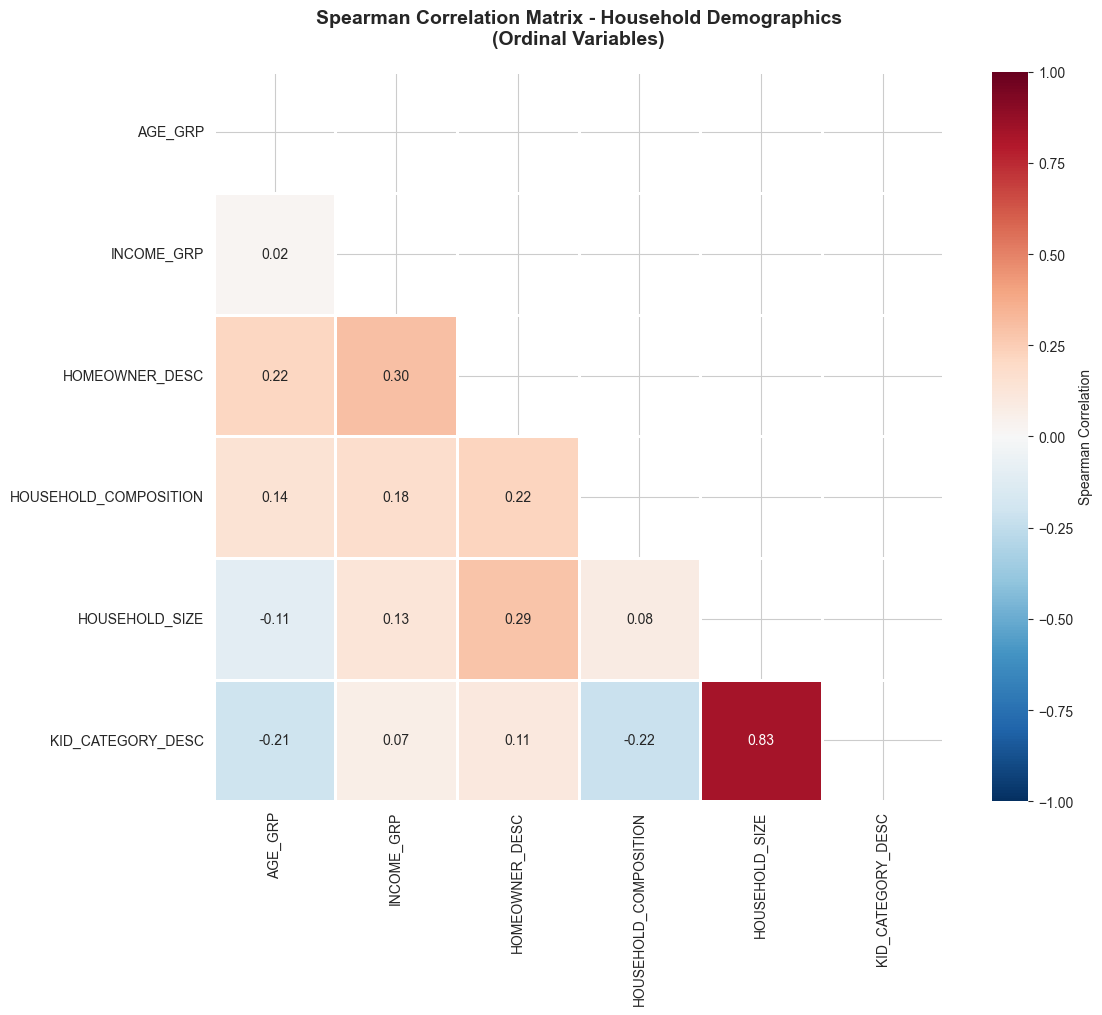


SIGNIFICANT CORRELATIONS (|ρ| > 0.3 and p < 0.05)
    Variable 1        Variable 2  Correlation       P-value
HOUSEHOLD_SIZE KID_CATEGORY_DESC     0.829595 2.087506e-204
    INCOME_GRP    HOMEOWNER_DESC     0.300106  3.916247e-18


In [73]:
ordinal_mappings = {
    'AGE_GRP': {
        'Age Group1': 1,
        'Age Group2': 2,
        'Age Group3': 3,
        'Age Group4': 4,
        'Age Group5': 5,
        'Age Group6': 6
    },
    'INCOME_GRP': {
        'Level1': 1, 'Level2': 2, 'Level3': 3, 'Level4': 4,
        'Level5': 5, 'Level6': 6, 'Level7': 7, 'Level8': 8,
        'Level9': 9, 'Level10': 10, 'Level11': 11, 'Level12': 12
    },
    'HOMEOWNER_DESC': {
        'Renter': 1,
        'Probable Renter': 2,
        'Unknown': 3,
        'Probable Owner': 4,
        'Homeowner': 5
    },
    'HOUSEHOLD_COMPOSITION': {
        'Group1': 1, 'Group2': 2, 'Group3': 3,
        'Group4': 4, 'Group5': 5, 'Group6': 6
    },
    'HOUSEHOLD_SIZE': {
        '1': 1, '2': 2, '3': 3, '4': 4, '5+': 5
    },
    'KID_CATEGORY_DESC': {
        'None/Unknown': 0,
        '1': 1,
        '2': 2,
        '3+': 3
    }
}

df_encoded = df_demo.copy()
for col, mapping in ordinal_mappings.items():
    if col in df_encoded.columns:
        df_encoded[f'{col}_encoded'] = df_encoded[col].map(mapping)

encoded_cols = [f'{col}_encoded' for col in ordinal_mappings.keys() if col in df_demo.columns]
df_corr = df_encoded[encoded_cols].copy()
df_corr.columns = [col.replace('_encoded', '') for col in df_corr.columns]

corr_matrix = df_corr.corr(method='spearman')

# Calculate p-values
n = len(df_corr.dropna())
p_values = pd.DataFrame(
    np.zeros_like(corr_matrix), 
    columns=corr_matrix.columns, 
    index=corr_matrix.index
)

for i, col1 in enumerate(df_corr.columns):
    for j, col2 in enumerate(df_corr.columns):
        if i != j:
            valid_data = df_corr[[col1, col2]].dropna()
            if len(valid_data) > 0:
                _, p_val = stats.spearmanr(valid_data[col1], valid_data[col2])
                p_values.iloc[i, j] = p_val


fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', center=0, vmin=-1,  vmax=1, 
    square=True, linewidths=1, cbar_kws={'label': 'Spearman Correlation'}, ax=ax
)
plt.title(
    'Spearman Correlation Matrix - Household Demographics\n(Ordinal Variables)',  
    fontsize=14, fontweight='bold', pad=20
)
plt.tight_layout()
plt.show()

# Print correlation summary
print("\n" + "="*80)
print("SIGNIFICANT CORRELATIONS (|ρ| > 0.3 and p < 0.05)")
print("="*80)

significant_corrs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        p_val = p_values.iloc[i, j]
        
        if abs(corr_val) > 0.3 and p_val < 0.05:
            significant_corrs.append({
                'Variable 1': corr_matrix.columns[i],
                'Variable 2': corr_matrix.columns[j],
                'Correlation': corr_val,
                'P-value': p_val
            })

if significant_corrs:
    df_sig = pd.DataFrame(significant_corrs).sort_values('Correlation', 
                                                          key=abs, 
                                                          ascending=False)
    print(df_sig.to_string(index=False))



### 2. transaction_data

**Loyalty card price (after loyalty discount)**
loyalty_price = (sales_value - (retail_disc + coupon_match_disc)) / quantity

**Non-loyalty card price (shelf price)**
regular_price = (sales_value - coupon_match_disc) / quantity

**Actual amount customer paid (when using coupon)**
customer_paid = sales_value - coupon_disc

In [54]:
df_trans = pd.read_csv(
    DATA_PATH / 'transaction_data.csv'
)

df_trans.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [55]:
df_trans[['DAY', 'WEEK_NO', 'QUANTITY', 'SALES_VALUE', 'RETAIL_DISC', 'TRANS_TIME', 'COUPON_DISC', 'COUPON_MATCH_DISC']].describe()

# outliers.. 
# 1. Quantity == 0
# 2. RETAIL_DISC > 0

,DAY,WEEK_NO,QUANTITY,SALES_VALUE,RETAIL_DISC,TRANS_TIME,COUPON_DISC,COUPON_MATCH_DISC
count,2.595732e+06,2.595732e+06,2.595732e+06,2.595732e+06,2.595732e+06,2.595732e+06,2.595732e+06,2.595732e+06
mean,3.887562e+02,5.622150e+01,1.004286e+02,3.104120e+00,-5.387054e-01,1.561586e+03,-1.641600e-02,-2.918564e-03
std,1.897210e+02,2.710223e+01,1.153436e+03,4.182274e+00,1.249191e+00,3.998378e+02,2.168410e-01,3.969004e-02
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,-1.800000e+02,0.000000e+00,-5.593000e+01,-7.700000e+00
25%,2.290000e+02,3.300000e+01,1.000000e+00,1.290000e+00,-6.900000e-01,1.308000e+03,0.000000e+00,0.000000e+00
50%,3.900000e+02,5.600000e+01,1.000000e+00,2.000000e+00,-1.000000e-02,1.613000e+03,0.000000e+00,0.000000e+00
75%,5.530000e+02,8.000000e+01,1.000000e+00,3.490000e+00,0.000000e+00,1.843000e+03,0.000000e+00,0.000000e+00
max,7.110000e+02,1.020000e+02,8.963800e+04,8.400000e+02,3.990000e+00,2.359000e+03,0.000000e+00,0.000000e+00


In [56]:
df_trans.isnull().sum().to_frame().T

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,0,0,0,0,0,0,0,0,0,0,0,0


In [57]:
df_trans[df_trans['QUANTITY'] == 0] # outliers

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
97,744,26985165432,1,5978648,0,0.0,31582,0.0,1119,1,0.0,0.0
128,1287,26985336468,1,5978648,0,0.0,304,0.0,1351,1,0.0,0.0
249,2305,26996870743,2,5978656,0,0.0,414,0.0,1300,1,-1.0,0.0
293,271,26997082949,2,5978656,0,0.0,329,0.0,1719,1,-2.0,0.0
694,315,27008952267,3,957951,0,0.0,327,0.0,1707,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2595140,1146,42289881473,711,5978648,0,0.0,304,0.0,1456,102,0.0,0.0
2595262,539,42289891395,711,5978648,0,0.0,380,0.0,1232,102,0.0,0.0
2595280,2338,42289891597,711,5978656,0,0.0,380,0.0,1258,102,-1.0,0.0
2595563,1098,42289918722,711,5978648,0,0.0,343,0.0,1447,102,0.0,0.0


In [58]:
df_trans[df_trans['RETAIL_DISC'] > 0] # outliers

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
968972,1306,31624096856,310,990941,0,1.000000e-02,340,1.000000e-02,2253,45,0.0,0.0
1001608,1306,31735306143,318,7409789,0,0.000000e+00,381,2.220446e-16,1232,46,0.0,0.0
1023085,1321,31803641901,323,1051069,0,0.000000e+00,364,5.551115e-17,1931,47,0.0,0.0
1023086,1321,31803641901,323,1055863,0,0.000000e+00,364,5.551115e-17,1931,47,0.0,0.0
1067337,37,31944616637,334,8090539,0,0.000000e+00,381,2.220446e-16,1434,48,0.0,0.0
1143255,2241,32173242560,353,995242,0,0.000000e+00,296,2.220446e-16,2325,51,0.0,0.0
1210504,923,32446036423,369,1047226,0,0.000000e+00,410,1.110223e-16,1541,53,0.0,0.0
1215551,1535,32478752229,370,999270,1,7.980000e+00,360,3.990000e+00,1852,54,0.0,0.0
1216489,2491,32478901200,370,13945244,0,4.440892e-16,389,1.110223e-16,1315,54,0.0,0.0
1271754,623,32704598135,384,5995423,1,5.100000e-01,381,2.600000e-01,1950,56,0.0,0.0


In [59]:
# delete outliers
df_trans = df_trans[(df_trans['QUANTITY'] > 0) & (df_trans['RETAIL_DISC'] <= 0)]


# - (discount)
df_trans = df_trans.assign(**{
    'COUPON_MATCH_DISC': - df_trans['COUPON_MATCH_DISC'],
    'COUPON_DISC': - df_trans['COUPON_DISC'],
    'RETAIL_DISC': - df_trans['RETAIL_DISC']
})


# derived columns
df_trans = df_trans.assign(**{
    'REGULAR_PRICE': lambda elem: (elem['SALES_VALUE'] - elem['COUPON_MATCH_DISC']) / elem['QUANTITY'],
    'LOYALTY_PRICE': lambda elem: elem['SALES_VALUE'] - (elem['RETAIL_DISC'] + elem['COUPON_MATCH_DISC']) / elem['QUANTITY'],
    'ACTUAL_SPENT': lambda elem: elem['SALES_VALUE'] - elem['COUPON_DISC']
})

df_trans.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,REGULAR_PRICE,LOYALTY_PRICE,ACTUAL_SPENT
0,2375,26984851472,1,1004906,1,1.39,364,0.60,1631,1,-0.0,-0.0,1.39,0.79,1.39
1,2375,26984851472,1,1033142,1,0.82,364,-0.00,1631,1,-0.0,-0.0,0.82,0.82,0.82
2,2375,26984851472,1,1036325,1,0.99,364,0.30,1631,1,-0.0,-0.0,0.99,0.69,0.99
3,2375,26984851472,1,1082185,1,1.21,364,-0.00,1631,1,-0.0,-0.0,1.21,1.21,1.21
4,2375,26984851472,1,8160430,1,1.50,364,0.39,1631,1,-0.0,-0.0,1.50,1.11,1.50


In [60]:
print('# of households: ', len(df_trans.household_key.drop_duplicates()))
print('# of stores: ', len(df_trans.STORE_ID.drop_duplicates()))
print('# of transactions: ', len(df_trans))
print('# of baskets: ', len(df_trans.BASKET_ID.drop_duplicates()))
print('# of product: ', len(df_trans.PRODUCT_ID.drop_duplicates()))

# of households:  2500
# of stores:  582
# of transactions:  2581260
# of baskets:  275889
# of product:  92015


In [61]:
df_trans_hh = df_trans.groupby('household_key').agg(**{
    'transaction': ('household_key', 'size'),
    'basket_id_count': ('BASKET_ID', 'nunique'),
    'product_id_count': ('PRODUCT_ID', 'nunique'),
    'coupon_disc': ('COUPON_DISC', 'sum'),
    'total_spend': ('ACTUAL_SPENT', 'sum')
})
                                 
df_trans_hh.describe().T

,count,mean,std,min,25%,50%,75%,max
transaction,2500.0,1032.504000,993.279847,4.00,321.0000,730.000,1445.5000,6775.00
basket_id_count,2500.0,110.355600,115.433111,1.00,38.0000,78.000,142.0000,1298.00
product_id_count,2500.0,558.067600,434.335856,4.00,230.0000,453.000,784.0000,3144.00
coupon_disc,2500.0,12.913204,32.478275,0.00,0.0000,2.500,10.4125,412.68
total_spend,2500.0,3210.057856,3335.156106,8.17,966.4775,2151.765,4397.4025,38289.21


## tmp

In [53]:
# transaction stats by household

df_trans_hh = df_trans.groupby('household_key').agg(**{
    'transaction': ('household_key', 'size'),
    'basket_id_count': ('BASKET_ID', 'nunique'),
    'product_id_count': ('PRODUCT_ID', 'nunique'),
    'retail_disc': ('RETAIL_DISC', 'sum'),
    'coupon_disc': ('COUPON_DISC', 'sum'),
    'total_spend': ('SALES_VALUE', 'sum')
})
                                 
df_trans_hh.describe().T

,count,mean,std,min,25%,50%,75%,max
transaction,2500.0,511.297200,507.175344,3.00,153.0000,357.500,704.50,4154.00
basket_id_count,2500.0,88.957200,86.239689,1.00,32.0000,66.000,116.25,1055.00
product_id_count,2500.0,298.860800,243.207060,3.00,118.7500,235.000,418.25,1884.00
retail_disc,2500.0,0.000000,0.000000,0.00,0.0000,0.000,0.00,0.00
coupon_disc,2500.0,-4.627540,13.314793,-261.44,-3.3600,-0.500,0.00,0.00
total_spend,2500.0,1600.534192,1745.385402,6.83,455.3875,1065.315,2082.76,20701.37


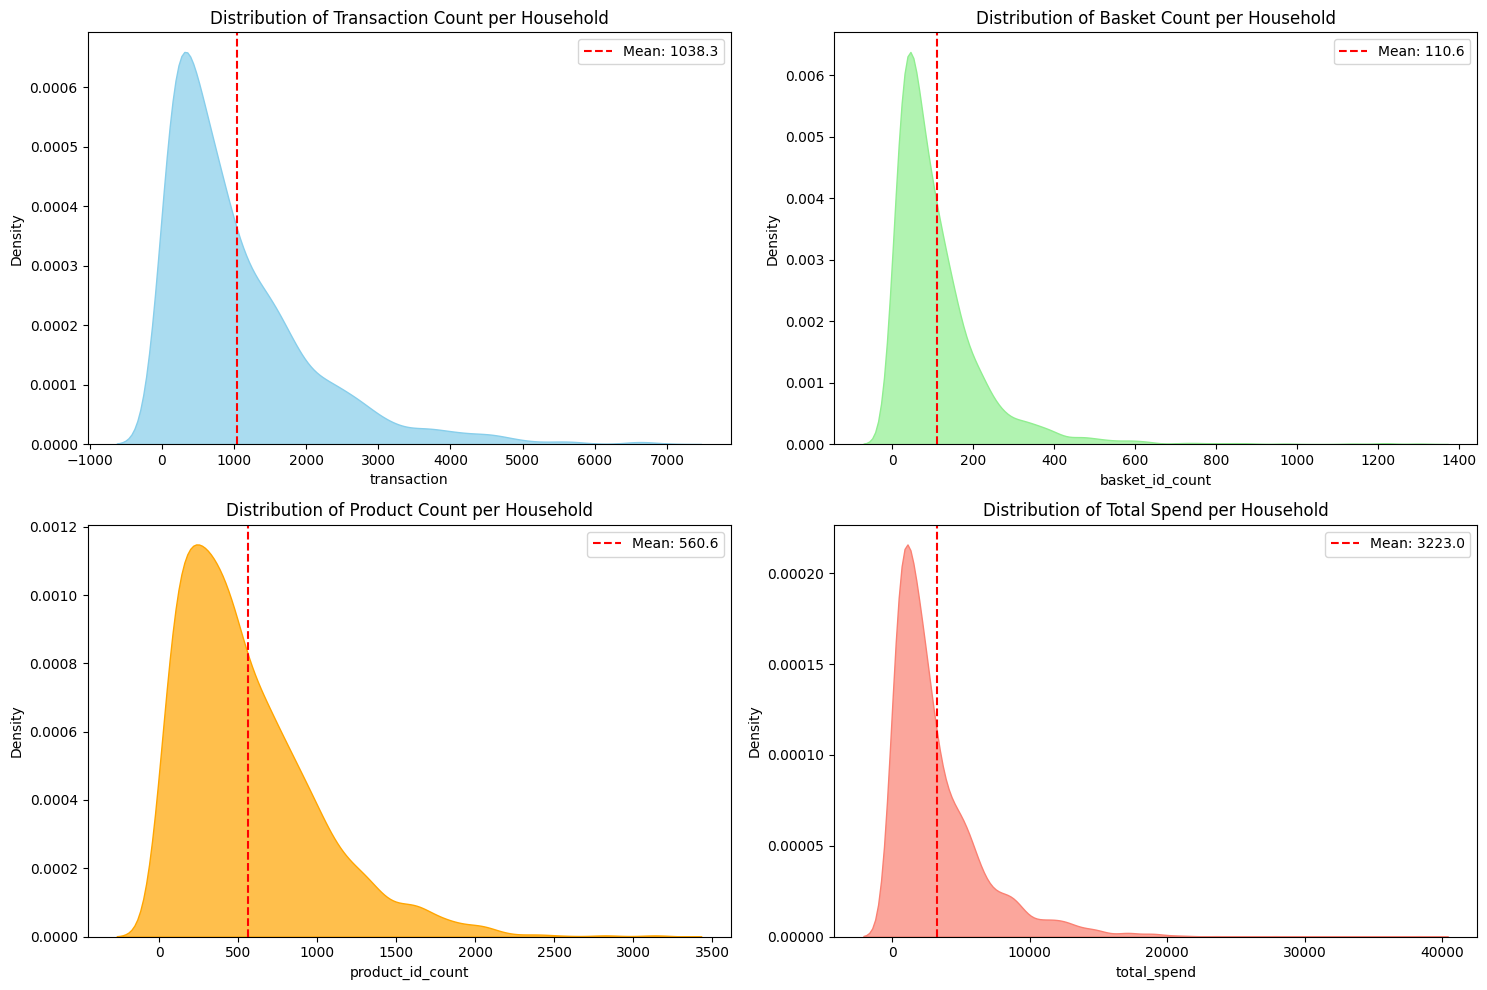

In [115]:
# 개별 KDE plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Transaction KDE
sns.kdeplot(data=df_trans_hh, x='transaction', ax=axes[0,0], 
           fill=True, color='skyblue', alpha=0.7)
axes[0,0].set_title('Distribution of Transaction Count per Household')
axes[0,0].axvline(df_trans_hh['transaction'].mean(), color='red', 
                  linestyle='--', label=f'Mean: {df_trans_hh["transaction"].mean():.1f}')
axes[0,0].legend()

# Basket ID Count KDE
sns.kdeplot(data=df_trans_hh, x='basket_id_count', ax=axes[0,1], 
           fill=True, color='lightgreen', alpha=0.7)
axes[0,1].set_title('Distribution of Basket Count per Household')
axes[0,1].axvline(df_trans_hh['basket_id_count'].mean(), color='red', 
                  linestyle='--', label=f'Mean: {df_trans_hh["basket_id_count"].mean():.1f}')
axes[0,1].legend()

# Product ID Count KDE
sns.kdeplot(data=df_trans_hh, x='product_id_count', ax=axes[1,0], 
           fill=True, color='orange', alpha=0.7)
axes[1,0].set_title('Distribution of Product Count per Household')
axes[1,0].axvline(df_trans_hh['product_id_count'].mean(), color='red', 
                  linestyle='--', label=f'Mean: {df_trans_hh["product_id_count"].mean():.1f}')
axes[1,0].legend()

# Total Spend KDE
sns.kdeplot(data=df_trans_hh, x='total_spend', ax=axes[1,1], 
           fill=True, color='salmon', alpha=0.7)
axes[1,1].set_title('Distribution of Total Spend per Household')
axes[1,1].axvline(df_trans_hh['total_spend'].mean(), color='red', 
                  linestyle='--', label=f'Mean: {df_trans_hh["total_spend"].mean():.1f}')
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [149]:
# sales by week

df_trans_day = df_trans.groupby('DAY').agg(**{
    'transaction': ('household_key', 'size'),
    'basket_id_count': ('BASKET_ID', 'nunique'),
    'product_id_count': ('PRODUCT_ID', 'nunique'),
    'total_spend': ('SALES_VALUE', 'sum')
})
df_trans_day.T

DAY,1,2,3,4,5,6,7,8,9,10,...,702,703,704,705,706,707,708,709,710,711
transaction,238.00,137.00,524.00,675.00,307.00,338.00,465.00,434.00,362.00,490.00,...,2926.00,3640.00,4557.00,5272.00,3709.00,3176.00,3154.0,3567.00,3843.00,4974.0
basket_id_count,16.00,13.00,44.00,44.00,25.00,37.00,34.00,43.00,39.00,51.00,...,377.00,367.00,427.00,433.00,403.00,363.00,384.0,379.00,406.00,448.0
product_id_count,226.00,132.00,471.00,615.00,291.00,316.00,439.00,392.00,343.00,457.00,...,2231.00,2583.00,3198.00,3609.00,2714.00,2419.00,2387.0,2559.00,2878.00,3495.0
total_spend,549.31,458.91,1560.37,1785.64,856.93,1008.15,1271.29,1203.85,1050.95,1714.38,...,9818.26,11677.97,14173.15,16477.93,11443.89,10632.36,9949.9,11245.74,12758.04,15938.7


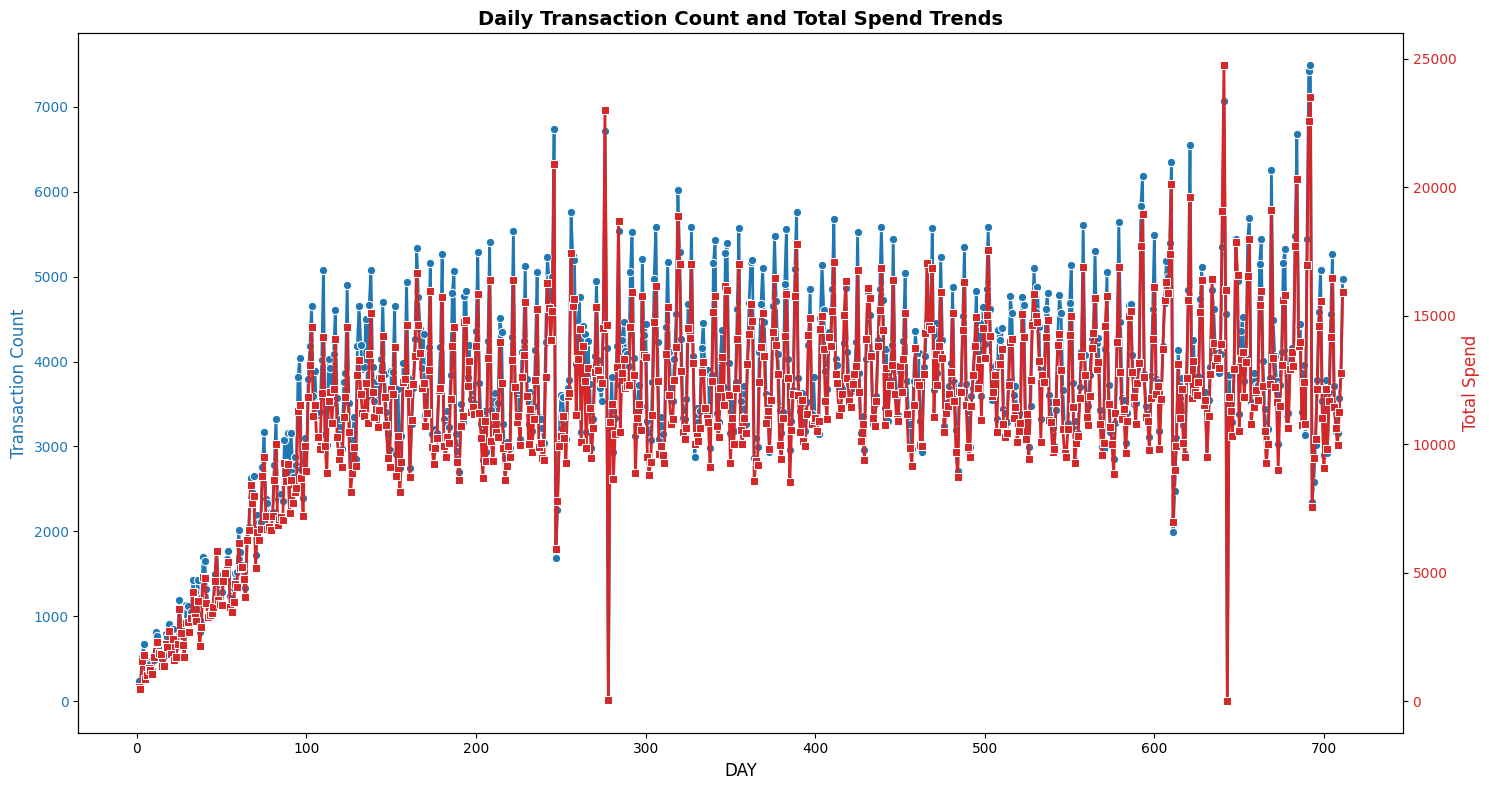

In [154]:
df_day_melted = df_trans_day.reset_index().melt(
    id_vars=['DAY'], 
    value_vars=['transaction', 'total_spend'],
    var_name='metric', 
    value_name='value'
)

# 그래프 생성
fig, ax1 = plt.subplots(figsize=(15, 8))

# transaction data만 필터링해서 첫 번째 축에 그리기
transaction_data = df_day_melted[df_day_melted['metric'] == 'transaction']
sns.lineplot(data=transaction_data, x='DAY', y='value', 
             ax=ax1, color='tab:blue', marker='o', linewidth=2)

ax1.set_xlabel('DAY', fontsize=12)
ax1.set_ylabel('Transaction Count', color='tab:blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 두 번째 y축 생성
ax2 = ax1.twinx()

# total_spend data만 필터링해서 두 번째 축에 그리기
spend_data = df_day_melted[df_day_melted['metric'] == 'total_spend']
sns.lineplot(data=spend_data, x='DAY', y='value', 
             ax=ax2, color='tab:red', marker='s', linewidth=2)

ax2.set_ylabel('Total Spend', color='tab:red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='tab:red')

# 제목
plt.title('Daily Transaction Count and Total Spend Trends', 
          fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [113]:
# sales by week

df_trans_week = df_trans.groupby('WEEK_NO').agg(**{
    'transaction': ('household_key', 'size'),
    'basket_id_count': ('BASKET_ID', 'nunique'),
    'product_id_count': ('PRODUCT_ID', 'nunique'),
    'total_spend': ('SALES_VALUE', 'sum')
})
df_trans_week.T

WEEK_NO,1,2,3,4,5,6,7,8,9,10,...,93,94,95,96,97,98,99,100,101,102
transaction,1881.00,3675.00,4803.0,5379.00,7168.00,8896.0,8980.00,10428.00,10585.00,13543.00,...,24888.00,31233.00,29067.00,28373.00,29208.00,31153.00,32256.00,28902.0,26613.00,22423.00
basket_id_count,142.00,324.00,482.0,545.00,757.00,861.0,999.00,1086.00,1212.00,1553.00,...,2547.00,3005.00,2878.00,2824.00,2913.00,3037.00,2851.00,2793.0,2682.00,2383.00
product_id_count,1543.00,2736.00,3303.0,3692.00,4549.00,5422.0,5395.00,6005.00,5984.00,7016.00,...,10886.00,12100.00,11664.00,11425.00,11536.00,12067.00,12277.00,12009.0,11137.00,10320.00
total_spend,5211.16,10821.35,13498.2,15965.99,20139.82,24923.9,28073.97,31793.77,31244.17,42994.38,...,80832.16,96964.24,88895.06,86810.11,88839.26,98949.62,101363.92,93063.1,84407.25,71968.63


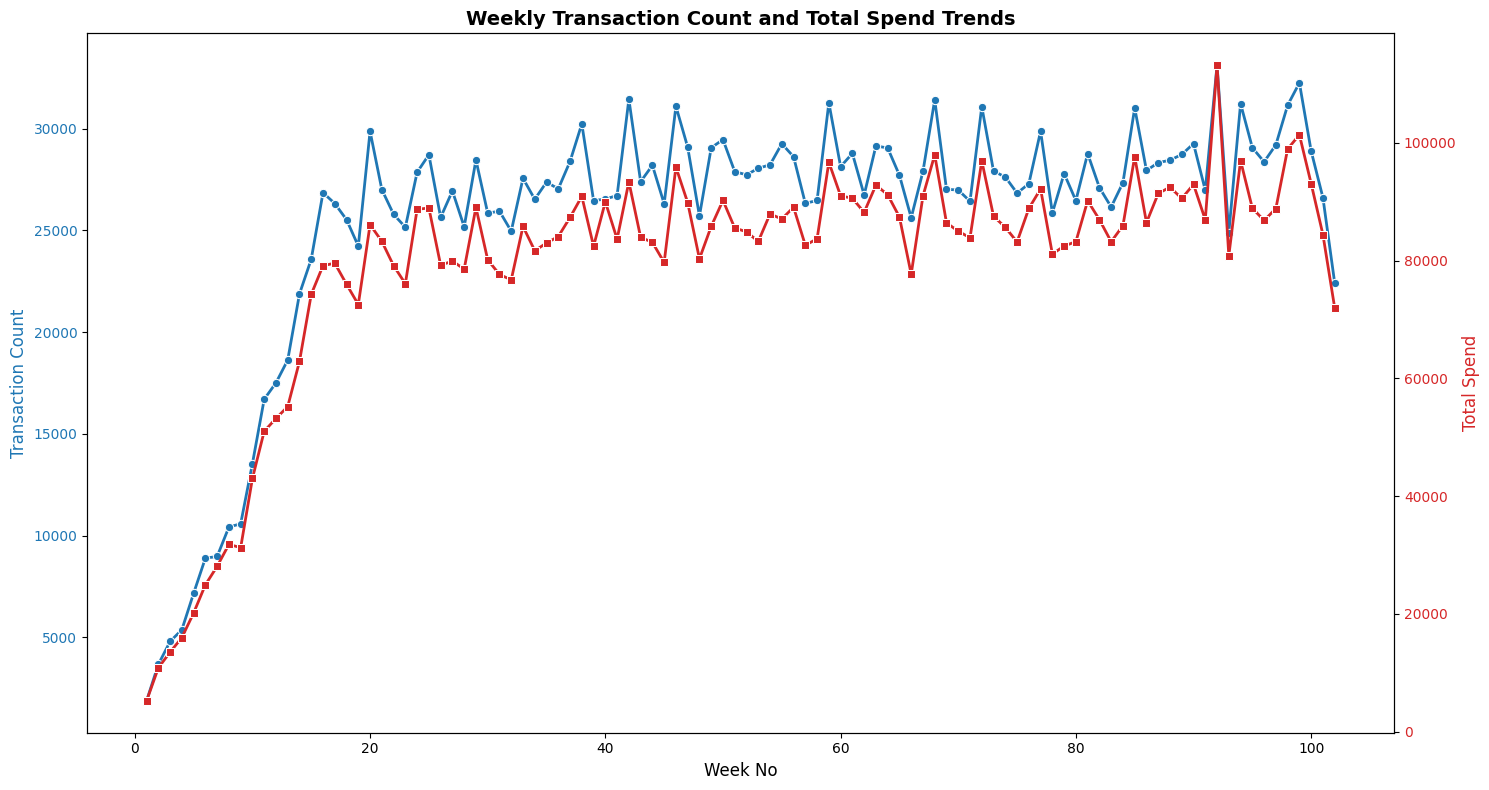

In [152]:
df_week_melted = df_trans_week.reset_index().melt(
    id_vars=['WEEK_NO'], 
    value_vars=['transaction', 'total_spend'],
    var_name='metric', 
    value_name='value'
)

# 그래프 생성
fig, ax1 = plt.subplots(figsize=(15, 8))

# transaction data만 필터링해서 첫 번째 축에 그리기
transaction_data = df_week_melted[df_week_melted['metric'] == 'transaction']
sns.lineplot(data=transaction_data, x='WEEK_NO', y='value', 
             ax=ax1, color='tab:blue', marker='o', linewidth=2)

ax1.set_xlabel('Week No', fontsize=12)
ax1.set_ylabel('Transaction Count', color='tab:blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 두 번째 y축 생성
ax2 = ax1.twinx()

# total_spend data만 필터링해서 두 번째 축에 그리기
spend_data = df_week_melted[df_week_melted['metric'] == 'total_spend']
sns.lineplot(data=spend_data, x='WEEK_NO', y='value', 
             ax=ax2, color='tab:red', marker='s', linewidth=2)

ax2.set_ylabel('Total Spend', color='tab:red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='tab:red')

# 제목
plt.title('Weekly Transaction Count and Total Spend Trends', 
          fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [139]:
df_demo_trans = pd.merge(
    df_demo, df_trans_hh, how='left', on='household_key'
).assign(**{
    'high_spend': lambda elem: np.where(
        elem['total_spend'] > df_trans_hh['total_spend'].quantile(0.75), 1, 0
    ), 'high_visit': lambda elem: np.where(
        elem['basket_id_count'] > df_trans_hh['basket_id_count'].quantile(0.75), 1, 0
    )
})

df_demo_trans

,classification_1,classification_2,classification_3,HOMEOWNER_DESC,classification_5,classification_4,KID_CATEGORY_DESC,household_key,transaction,basket_id_count,product_id_count,total_spend,high_spend,high_visit
0,Age Group6,X,Level4,Homeowner,Group5,2,None/Unknown,1,1727,86,677,4330.16,0,0
1,Age Group4,X,Level5,Homeowner,Group5,2,None/Unknown,7,1286,59,829,3400.05,0,0
2,Age Group2,Y,Level3,Unknown,Group4,3,1,8,1979,113,1288,5534.97,1,0
3,Age Group2,Y,Level6,Homeowner,Group4,4,2,13,2348,275,1008,13190.92,1,1
4,Age Group4,Z,Level5,Homeowner,Group3,1,None/Unknown,16,517,98,282,1512.02,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,Age Group3,Y,Level5,Homeowner,Group5,2,None/Unknown,2494,617,35,484,2120.93,0,0
797,Age Group4,X,Level6,Homeowner,Group6,3,1,2496,1489,63,758,4339.66,0,0
798,Age Group4,Y,Level4,Unknown,Group2,1,None/Unknown,2497,1962,221,991,7111.98,1,1
799,Age Group2,Y,Level5,Homeowner,Group5,2,None/Unknown,2498,859,172,642,2601.60,0,1


In [138]:
from tableone import tableone

tableone_cols = ['classification_1', 'classification_2', 'classification_3', 'HOMEOWNER_DESC', 'classification_5', 'classification_4', 'KID_CATEGORY_DESC']

tableone(
    data=df_demo_trans, categorical=tableone_cols, groupby='high_spend', pval=True, htest_name=True
)

Grouped by high_spend                                                                                                     
                                                          Missing          Overall               0                1 P-Value                                       Test
n                                                                              801             373              428                                                   
classification_1, n (%)     Age Group1                                    46 (5.7)        24 (6.4)         22 (5.1)   0.003                                Chi-squared
                            Age Group2                                  142 (17.7)       64 (17.2)        78 (18.2)                                                   
                            Age Group3                                  194 (24.2)       74 (19.8)       120 (28.0)                                                   
                            Age Group4                                  288 (36.0)      133 (35.7)       155 (36.2)                                                   
                            Age Group5                                    59 (7.4)        30 (8.0)         29 (6.8)                                                   
                            Age Group6                                    72 (9.0)       48 (12.9)         24 (5.6)                                                   
classification_2, n (%)     X                                           340 (42.4)      145 (38.9)       195 (45.6)   0.149                                Chi-squared
                            Y                                           344 (42.9)      172 (46.1)       172 (40.2)                                                   
                            Z                                           117 (14.6)       56 (15.0)        61 (14.3)                                                   
classification_3, n (%)     Level1                                        61 (7.6)        26 (7.0)         35 (8.2)  <0.001  Chi-squared (warning: expected count < 5)
                            Level10                                       11 (1.4)         5 (1.3)          6 (1.4)                                                   
                            Level11                                        5 (0.6)         2 (0.5)          3 (0.7)                                                   
                            Level12                                       11 (1.4)         2 (0.5)          9 (2.1)                                                   
                            Level2                                        74 (9.2)       47 (12.6)         27 (6.3)                                                   
                            Level3                                        77 (9.6)       39 (10.5)         38 (8.9)                                                   
                            Level4                                      172 (21.5)      100 (26.8)        72 (16.8)                                                   
                            Level5                                      192 (24.0)       82 (22.0)       110 (25.7)                                                   
                            Level6                                       96 (12.0)       43 (11.5)        53 (12.4)                                                   
                            Level7                                        34 (4.2)        11 (2.9)         23 (5.4)                                                   
                            Level8                                        38 (4.7)         9 (2.4)         29 (6.8)                                                   
                            Level9                                        30 (3.7)         7 (1.9)         23 (5.4)                                                   
HOMEOWNER_DESC, n (%)       Homeowne

In [141]:
from tableone import tableone

tableone_cols = ['classification_1', 'classification_2', 'classification_3', 'HOMEOWNER_DESC', 'classification_5', 'classification_4', 'KID_CATEGORY_DESC']

tableone(
    data=df_demo_trans, categorical=tableone_cols, groupby='high_visit', pval=True, htest_name=True
)

Grouped by high_visit                                                                                                      
                                                          Missing          Overall                0                1 P-Value                                       Test
n                                                                              801              412              389                                                   
classification_1, n (%)     Age Group1                                    46 (5.7)         21 (5.1)         25 (6.4)   0.462                                Chi-squared
                            Age Group2                                  142 (17.7)        76 (18.4)        66 (17.0)                                                   
                            Age Group3                                  194 (24.2)        94 (22.8)       100 (25.7)                                                   
                            Age Group4                                  288 (36.0)       149 (36.2)       139 (35.7)                                                   
                            Age Group5                                    59 (7.4)         28 (6.8)         31 (8.0)                                                   
                            Age Group6                                    72 (9.0)        44 (10.7)         28 (7.2)                                                   
classification_2, n (%)     X                                           340 (42.4)       192 (46.6)       148 (38.0)   0.011                                Chi-squared
                            Y                                           344 (42.9)       156 (37.9)       188 (48.3)                                                   
                            Z                                           117 (14.6)        64 (15.5)        53 (13.6)                                                   
classification_3, n (%)     Level1                                        61 (7.6)         26 (6.3)         35 (9.0)   0.440  Chi-squared (warning: expected count < 5)
                            Level10                                       11 (1.4)          6 (1.5)          5 (1.3)                                                   
                            Level11                                        5 (0.6)          5 (1.2)          0 (0.0)                                                   
                            Level12                                       11 (1.4)          4 (1.0)          7 (1.8)                                                   
                            Level2                                        74 (9.2)         35 (8.5)        39 (10.0)                                                   
                            Level3                                        77 (9.6)         40 (9.7)         37 (9.5)                                                   
                            Level4                                      172 (21.5)        93 (22.6)        79 (20.3)                                                   
                            Level5                                      192 (24.0)       100 (24.3)        92 (23.7)                                                   
                            Level6                                       96 (12.0)        55 (13.3)        41 (10.5)                                                   
                            Level7                                        34 (4.2)         15 (3.6)         19 (4.9)                                                   
                            Level8                                        38 (4.7)         19 (4.6)         19 (4.9)                                                   
                            Level9                                        30 (3.7)         14 (3.4)         16 (4.1)                                                   
HOMEOWNER_DE

In [63]:
df_cmp = pd.read_csv(
    DATA_PATH / 'campaign_table.csv'
)
df_cmp.head()

,DESCRIPTION,household_key,CAMPAIGN
0,TypeA,17,26
1,TypeA,27,26
2,TypeA,212,26
3,TypeA,208,26
4,TypeA,192,26


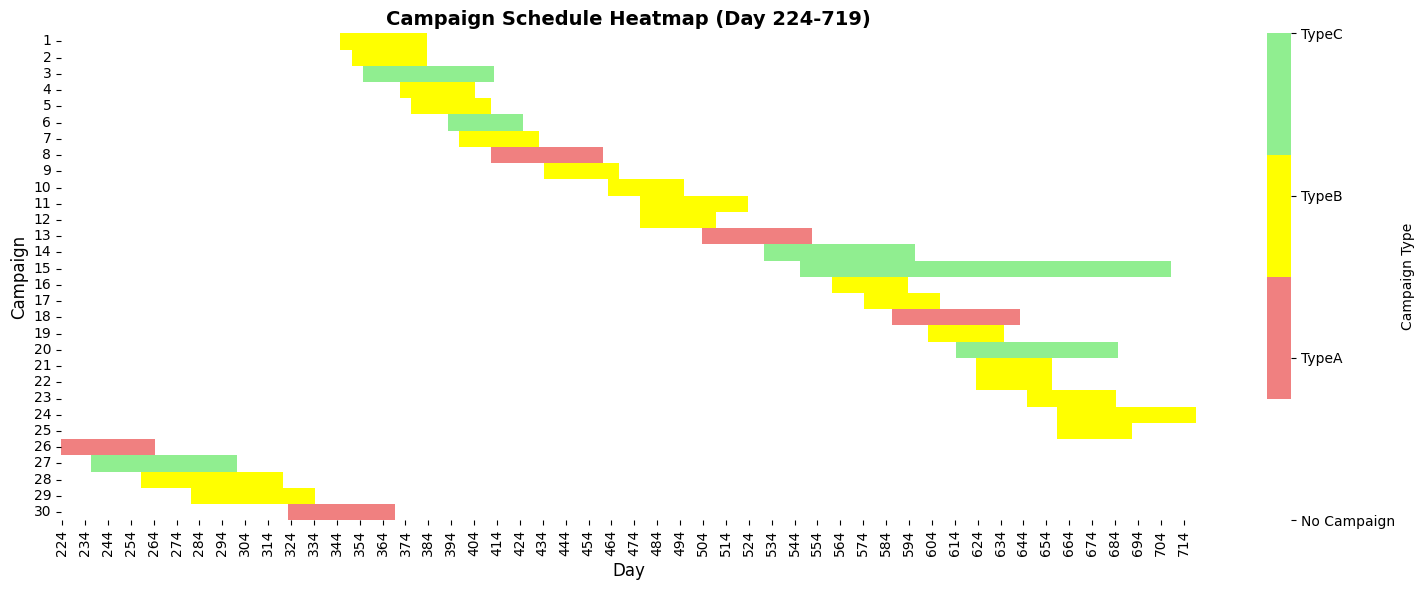

In [167]:
from matplotlib.colors import ListedColormap

def expand_campaign_days(df_cmp_desc):
    expanded_data = []
    
    for idx, row in df_cmp_desc.iterrows():
        # 각 캠페인의 시작일부터 종료일까지 모든 날짜 생성
        days = range(row['START_DAY'], row['END_DAY'] + 1)
        
        for day in days:
            expanded_data.append({
                'DAY': day,
                'CAMPAIGN': row['CAMPAIGN'],
                'DESCRIPTION': row['DESCRIPTION']
            })
    
    return pd.DataFrame(expanded_data)

# 캠페인 데이터 확장
df_campaign_expanded = expand_campaign_days(df_cmp_desc)

# Description을 숫자로 인코딩 (TypeA, TypeB, TypeC)
description_map = {'TypeA': 1, 'TypeB': 2, 'TypeC': 3}
df_campaign_expanded['DESCRIPTION_NUM'] = df_campaign_expanded['DESCRIPTION'].map(description_map)

# 캠페인이 진행되는 Day 범위만 사용
min_day = df_cmp_desc['START_DAY'].min()
max_day = df_cmp_desc['END_DAY'].max()

# 전체 Day x Campaign 매트릭스 생성
all_days = range(min_day, max_day + 1)
all_campaigns = df_cmp_desc['CAMPAIGN'].unique()

full_matrix = []
for day in all_days:
    for campaign in all_campaigns:
        # 해당 day에 해당 campaign이 진행 중인지 확인
        campaign_data = df_campaign_expanded[
            (df_campaign_expanded['DAY'] == day) & 
            (df_campaign_expanded['CAMPAIGN'] == campaign)
        ]
        
        if len(campaign_data) > 0:
            desc_num = campaign_data.iloc[0]['DESCRIPTION_NUM']
        else:
            desc_num = 0  # 캠페인이 진행되지 않는 경우
            
        full_matrix.append({
            'DAY': day,
            'CAMPAIGN': campaign,
            'DESCRIPTION_NUM': desc_num
        })

df_full = pd.DataFrame(full_matrix)

# Pivot 테이블 생성
pivot_matrix = df_full.pivot(index='CAMPAIGN', columns='DAY', values='DESCRIPTION_NUM')

# Heatmap 생성
fig, ax = plt.subplots(figsize=(15, 6))

# 커스텀 컬러맵 (0: 흰색, 1: TypeA, 2: TypeB, 3: TypeC)
colors = ['white', 'lightcoral', 'yellow', 'lightgreen']
cmap = ListedColormap(colors)

# Heatmap 그리기
sns.heatmap(pivot_matrix, 
           cmap=cmap,
           cbar_kws={'label': 'Campaign Type'},
           ax=ax,
           xticklabels=10,  # x축 라벨 간격 조정
           yticklabels=True)

# 컬러바 라벨 수정
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 1, 2, 3])
cbar.set_ticklabels(['No Campaign', 'TypeA', 'TypeB', 'TypeC'])

ax.set_xlabel('Day', fontsize=12)
ax.set_ylabel('Campaign', fontsize=12)
ax.set_title(f'Campaign Schedule Heatmap (Day {min_day}-{max_day})', 
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


In [169]:
print("Campaign Type Distribution:")
print(df_cmp_desc['DESCRIPTION'].value_counts())
print("\nCampaign Details:")
print(df_cmp_desc.groupby('DESCRIPTION').agg({
    'CAMPAIGN': 'count',
    'START_DAY': ['min', 'max'],
    'END_DAY': ['min', 'max']
}))

Campaign Type Distribution:
DESCRIPTION
TypeB    19
TypeC     6
TypeA     5
Name: count, dtype: int64

Campaign Details:
            CAMPAIGN START_DAY      END_DAY     
               count       min  max     min  max
DESCRIPTION                                     
TypeA              5       224  587     264  642
TypeB             19       259  659     320  719
TypeC              6       237  615     300  708


In [162]:
df_trans.DAY.max()

np.int64(711)

In [62]:
df_cmp_desc = pd.read_csv(
    DATA_PATH / 'campaign_desc.csv'
)
df_cmp_desc.head()

,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY
0,TypeB,24,659,719
1,TypeC,15,547,708
2,TypeB,25,659,691
3,TypeC,20,615,685
4,TypeB,23,646,684


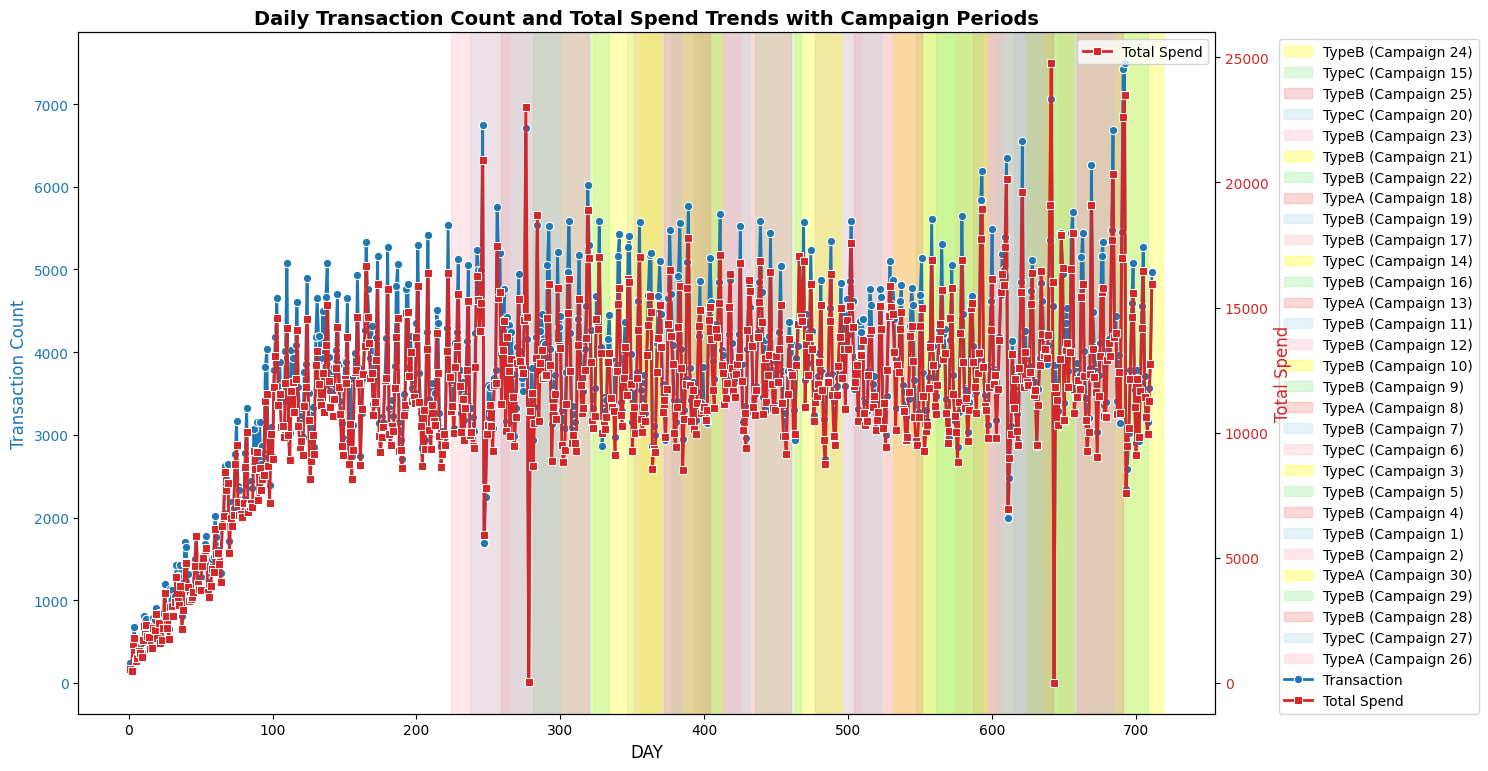

In [155]:
# 그래프 생성
fig, ax1 = plt.subplots(figsize=(15, 8))

# 캠페인 기간 표시
campaign_colors = ['yellow', 'lightgreen', 'lightcoral', 'lightblue', 'lightpink']

for idx, row in df_cmp_desc.iterrows():
    ax1.axvspan(row['START_DAY'], row['END_DAY'], 
                alpha=0.3, color=campaign_colors[idx % len(campaign_colors)],
                label=f"{row['DESCRIPTION']} (Campaign {row['CAMPAIGN']})")

# transaction data만 필터링해서 첫 번째 축에 그리기
transaction_data = df_day_melted[df_day_melted['metric'] == 'transaction']
sns.lineplot(data=transaction_data, x='DAY', y='value', 
             ax=ax1, color='tab:blue', marker='o', linewidth=2, label='Transaction')

ax1.set_xlabel('DAY', fontsize=12)
ax1.set_ylabel('Transaction Count', color='tab:blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 두 번째 y축 생성
ax2 = ax1.twinx()

# total_spend data만 필터링해서 두 번째 축에 그리기
spend_data = df_day_melted[df_day_melted['metric'] == 'total_spend']
sns.lineplot(data=spend_data, x='DAY', y='value', 
             ax=ax2, color='tab:red', marker='s', linewidth=2, label='Total Spend')

ax2.set_ylabel('Total Spend', color='tab:red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='tab:red')

# 범례 추가
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(1.05, 1))

# 제목
plt.title('Daily Transaction Count and Total Spend Trends with Campaign Periods', 
          fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

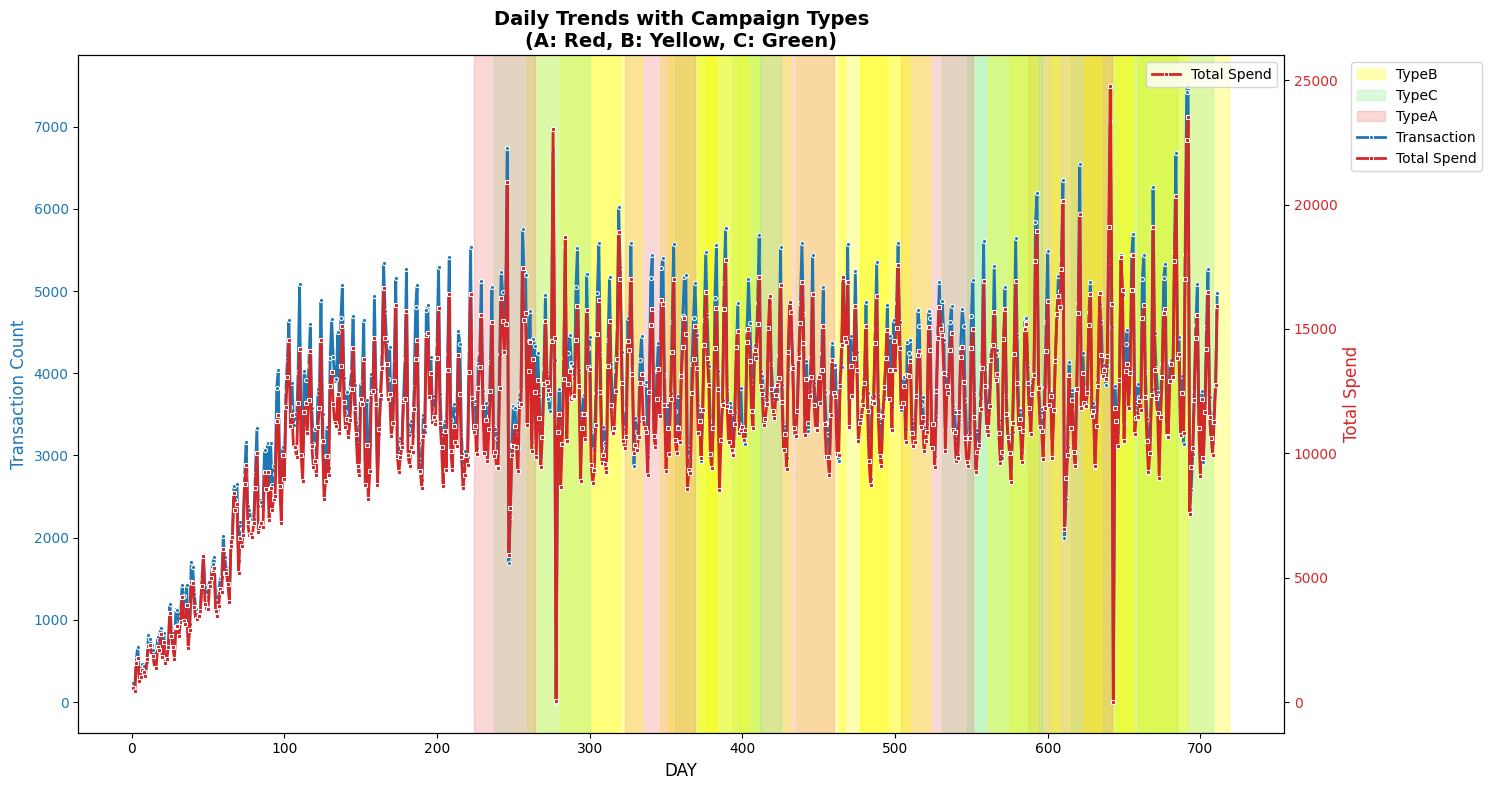

In [159]:
df_day_melted = df_trans_day.reset_index().melt(
    id_vars=['DAY'], 
    value_vars=['transaction', 'total_spend'],
    var_name='metric', 
    value_name='value'
)

# 그래프 생성
fig, ax1 = plt.subplots(figsize=(15, 8))

# 캠페인 타입별 색상 정의
type_colors = {
    'TypeA': 'lightcoral', 
    'TypeB': 'yellow', 
    'TypeC': 'lightgreen'
}

# 타입별로 한 번씩만 범례에 추가하기 위한 추적
added_types = set()

for idx, row in df_cmp_desc.iterrows():
    campaign_type = row['DESCRIPTION']
    color = type_colors.get(campaign_type, 'lightgray')
    
    # 범례 라벨 설정 (타입별로 한 번만)
    label = campaign_type if campaign_type not in added_types else ""
    if campaign_type not in added_types:
        added_types.add(campaign_type)
    
    ax1.axvspan(row['START_DAY'], row['END_DAY'], 
                alpha=0.3, color=color, label=label)

# transaction data
transaction_data = df_day_melted[df_day_melted['metric'] == 'transaction']
sns.lineplot(data=transaction_data, x='DAY', y='value', 
             ax=ax1, color='tab:blue', marker='o', linewidth=2, 
             label='Transaction', markersize=3)

ax1.set_xlabel('DAY', fontsize=12)
ax1.set_ylabel('Transaction Count', color='tab:blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 두 번째 y축
ax2 = ax1.twinx()

spend_data = df_day_melted[df_day_melted['metric'] == 'total_spend']
sns.lineplot(data=spend_data, x='DAY', y='value', 
             ax=ax2, color='tab:red', marker='s', linewidth=2, 
             label='Total Spend', markersize=3)

ax2.set_ylabel('Total Spend', color='tab:red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='tab:red')

# 범례
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, 
           bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Daily Trends with Campaign Types\n(A: Red, B: Yellow, C: Green)', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

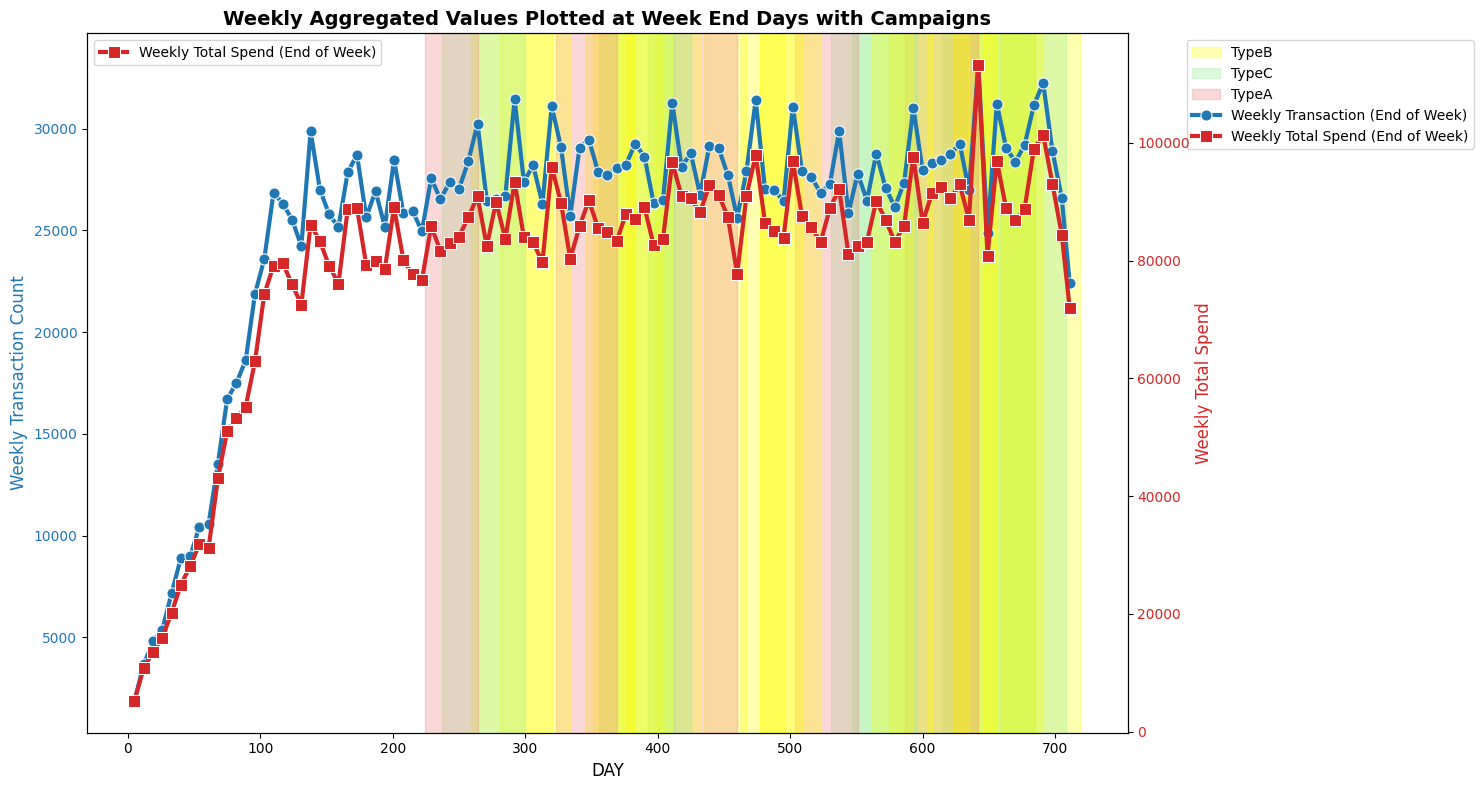

In [160]:
def get_week_day_mapping(df_trans):
    """실제 데이터에서 week별 마지막 day 추출"""
    week_day_map = df_trans.groupby('WEEK_NO')['DAY'].max().reset_index()
    return week_day_map

# 실제 week-day 매핑 생성
week_day_mapping = get_week_day_mapping(df_trans)  # 원본 transaction 데이터 사용

# Week 데이터와 Day 매핑 결합
df_week_with_day = df_trans_week.reset_index().merge(
    week_day_mapping, left_on='WEEK_NO', right_on='WEEK_NO'
)

# Melt 처리
df_week_day_melted = df_week_with_day.melt(
    id_vars=['DAY'], 
    value_vars=['transaction', 'total_spend'],
    var_name='metric', 
    value_name='value'
)

# 그래프 생성 (위와 동일한 plotting 코드)
fig, ax1 = plt.subplots(figsize=(15, 8))

# 캠페인 구간
type_colors = {'TypeA': 'lightcoral', 'TypeB': 'yellow', 'TypeC': 'lightgreen'}
added_types = set()
for idx, row in df_cmp_desc.iterrows():
    campaign_type = row['DESCRIPTION']
    color = type_colors.get(campaign_type, 'lightgray')
    label = campaign_type if campaign_type not in added_types else ""
    if campaign_type not in added_types:
        added_types.add(campaign_type)
    ax1.axvspan(row['START_DAY'], row['END_DAY'], alpha=0.3, color=color, label=label)

# 플롯팅
transaction_data = df_week_day_melted[df_week_day_melted['metric'] == 'transaction']
sns.lineplot(data=transaction_data, x='DAY', y='value', 
             ax=ax1, color='tab:blue', marker='o', linewidth=3, 
             markersize=8, label='Weekly Transaction (End of Week)')

ax1.set_xlabel('DAY', fontsize=12)
ax1.set_ylabel('Weekly Transaction Count', color='tab:blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
spend_data = df_week_day_melted[df_week_day_melted['metric'] == 'total_spend']
sns.lineplot(data=spend_data, x='DAY', y='value', 
             ax=ax2, color='tab:red', marker='s', linewidth=3, 
             markersize=8, label='Weekly Total Spend (End of Week)')

ax2.set_ylabel('Weekly Total Spend', color='tab:red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='tab:red')

# 범례
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Weekly Aggregated Values Plotted at Week End Days with Campaigns', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()